/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in less


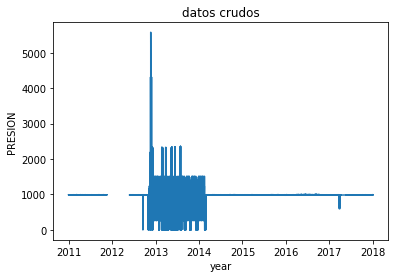

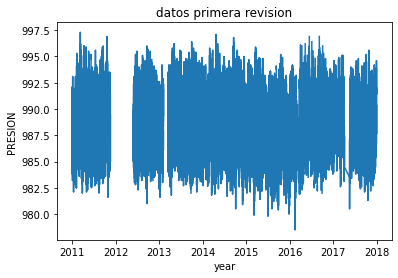

In [2]:
import numpy as np
import os
import datetime as dt
import calendar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pylab import *

MISS = -9999.9 # valor para asignarle a datos faltantes o invalidos

sta = 'PALANQUERO' # el nombre de la estacion 
var = 'PRESION'         # la variable a leer (como en el nombre del archivo)

fname=os.popen('ls '+sta+'_*_'+var+'.txt').read().strip()
f_in = open(fname,'r')
lines=f_in.readlines() # todo el archivo se lee como texto, y cada linea queda guardada como un elemento de una lista
f_in.close()

# para cada variable a leer se define una lista:
value = [] # value of variable read
time  = [] # time coordinate as datetime object
days  = [] # time coordinate in days since the first data point
years = [] # time coordinate in years
hour  = [] # local time in hours
month = [] # month


for line in lines[2:]: # se lee cada linea (excepto la primera)
    data=line.strip().split() 
    if data!=[]:
        valid=True
        ignore=False
        tt=data[1].split(':')
        temp_time = dt.datetime(year=np.int(data[0][:4]),month=np.int(data[0][4:6]),day=np.int(data[0][6:]),hour=np.int(tt[0]),minute=np.int(tt[1]),second=np.int(tt[2]),microsecond=0)
        if temp_time.second>=30: #aproxima la hora al minuto mas cercano
            temp_time = temp_time+dt.timedelta(seconds=(60-temp_time.second))
        if len(time)>0 and temp_time==time[-1]: # si ya existe un registro para la misma hora, se ignora
            valid=False
            ignore=True
        if data[2][0]=='-': # dato faltante
            valid=False
        if not ignore:
            if valid:
                value.append(np.float(data[2])) 
            else:
                value.append(np.nan)    # si hay dato faltante se guarda como np.nan
            time.append(temp_time)      # para cada dato se guarda su fecha y hora como un objeto datetime
            hour.append(temp_time.hour+temp_time.minute/60.+temp_time.second/3600.) # hora local en formato decimal
            month.append(temp_time.month) # el mes
            days.append((time[-1]-time[0]).total_seconds()/(3600.*24.)) # dias desde el primer registro
            if calendar.isleap(time[-1].year):
                N=366.
            else:
                N=365.
            years.append(time[-1].year + ((time[-1].timetuple().tm_yday - 1.) + (time[-1].hour+time[-1].minute/60. + time[-1].second/3600.)/24.)/N ) # tiempo en agnos (decimal)

# se convierten las listas a "arrays"
value   = np.asarray(value)
days    = np.asarray(days)
years   = np.asarray(years)
hour    = np.asarray(hour)
month   = np.asarray(month)
year    = years.astype(int)

plt.figure()
plt.title('datos crudos')
plt.plot(years,value)
plt.xlabel('year')
plt.ylabel(var)


if var=='PRESION':
    vmax=1000.
    vmin=970.

value_v2 = value
ind_atipicos1 = np.where(value>vmax)
ind_atipicos2 = np.where(value<vmin)
value_v2[ind_atipicos1]=value_v2[ind_atipicos2]=np.nan
# esto mismo se podria hacer en una sola linea:
#value_v2[np.where((value>vmax)+(value<vmin))]=np.nan

plt.figure()
plt.title('datos primera revision')
plt.plot(years,value_v2)
plt.xlabel('year')
plt.ylabel(var)
plt.show()

# se escriben los datos revisados a otro archivo de texto:
f_out = open(sta+'_'+var+'_v2.dat','w')
value_v2[np.where(np.isnan(value_v2))]=MISS
for i in range(value_v2.shape[0]):
    f_out.write('%04d %02d %02d %02d %02d %02d %.1f\n'%(time[i].year,time[i].month,time[i].day,time[i].hour,time[i].minute,time[i].second,value_v2[i]))
value_v2[np.where(value==MISS)]=np.nan
f_out.close()